In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import imageio
import os
import time
import math
import random
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Loading the dataset

In [29]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [32]:
X_train.shape

(60000, 28, 28)

In [30]:
for image, label in zip(X_train, Y_train):
	print(label)

5
0
4
1
9
2
1
3
1
4
3
5
3
6
1
7
2
8
6
9
4
0
9
1
1
2
4
3
2
7
3
8
6
9
0
5
6
0
7
6
1
8
7
9
3
9
8
5
9
3
3
0
7
4
9
8
0
9
4
1
4
4
6
0
4
5
6
1
0
0
1
7
1
6
3
0
2
1
1
7
9
0
2
6
7
8
3
9
0
4
6
7
4
6
8
0
7
8
3
1
5
7
1
7
1
1
6
3
0
2
9
3
1
1
0
4
9
2
0
0
2
0
2
7
1
8
6
4
1
6
3
4
5
9
1
3
3
8
5
4
7
7
4
2
8
5
8
6
7
3
4
6
1
9
9
6
0
3
7
2
8
2
9
4
4
6
4
9
7
0
9
2
9
5
1
5
9
1
2
3
2
3
5
9
1
7
6
2
8
2
2
5
0
7
4
9
7
8
3
2
1
1
8
3
6
1
0
3
1
0
0
1
7
2
7
3
0
4
6
5
2
6
4
7
1
8
9
9
3
0
7
1
0
2
0
3
5
4
6
5
8
6
3
7
5
8
0
9
1
0
3
1
2
2
3
3
6
4
7
5
0
6
2
7
9
8
5
9
2
1
1
4
4
5
6
4
1
2
5
3
9
3
9
0
5
9
6
5
7
4
1
3
4
0
4
8
0
4
3
6
8
7
6
0
9
7
5
7
2
1
1
6
8
9
4
1
5
2
2
9
0
3
9
6
7
2
0
3
5
4
3
6
5
8
9
5
4
7
4
2
7
3
4
8
9
1
9
2
8
7
9
1
8
7
4
1
3
1
1
0
2
3
9
4
9
2
1
6
8
4
7
7
4
4
9
2
5
7
2
4
4
2
1
9
7
2
8
7
6
9
2
2
3
8
1
6
5
1
1
0
2
6
4
5
8
3
1
5
1
9
2
7
4
4
4
8
1
5
8
9
5
6
7
9
9
3
7
0
9
0
6
6
2
3
9
0
7
5
4
8
0
9
4
1
2
8
7
1
2
6
1
0
3
0
1
1
8
2
0
3
9
4
0
5
0
6
1
7
7
8
1
9
2
0
5
1
2
2
7
3
5
4
9
7
1
8
3
9
6
0
3
1
1
2
6
3
5
7
6
8


In [10]:
input = np.array(X_train[0])

plt.imshow(input)
plt.show()

NameError: name 'X_train' is not defined

In [11]:
# Parameters
image_train_time = 350

min_frequency = 1
max_frequency = 50

In [12]:
pixel_x = 28
T = 350

def rf(inp):
	sca1 =  0.625
	sca2 =  0.125
	sca3 = -0.125
	sca4 = -.5

	#Receptive field kernel
	w = [[	sca4 ,sca3 , sca2 ,sca3 ,sca4],
	 	[	sca3 ,sca2 , sca1 ,sca2 ,sca3],
	 	[ 	sca2 ,sca1 , 	1 ,sca1 ,sca2],
	 	[	sca3 ,sca2 , sca1 ,sca2 ,sca3],
	 	[	sca4 ,sca3 , sca2 ,sca3 ,sca4]]

	pot = np.zeros([pixel_x,pixel_x])
	ran = [-2,-1,0,1,2]
	ox = 2
	oy = 2

	#Convolution
	for i in range(pixel_x):
		for j in range(pixel_x):
			summ = 0
			for m in ran:
				for n in ran:
					if (i+m)>=0 and (i+m)<=pixel_x-1 and (j+n)>=0 and (j+n)<=pixel_x-1:
						summ = summ + w[ox+m][oy+n]*inp[i+m][j+n]/255
			pot[i][j] = summ
	return pot		




In [13]:

def encode(pot):

	#initializing spike train
	train = []

	for l in range(pixel_x):
		for m in range(pixel_x):
		
			temp = np.zeros([(T+1),])

			#calculating firing rate proportional to the membrane potential
			freq = np.interp(pot[l][m], [np.min(pot),np.max(pot)], [1,50])

				
			time_period = math.ceil(T/freq)

			#generating spikes according to the firing rate
			time_of_spike = time_period
			if(pot[l][m]>0):
				while time_of_spike<(T+1):
					temp[int(time_of_spike)] = 1
					time_of_spike+= time_period
			train.append(temp)
	return train


In [14]:
def encode_image_to_spike_train(image: np.ndarray):
    spike_trains = []

    for x_position in range(image.shape[0]):
        for y_position in range(image.shape[1]):

            pixel_value = image[x_position][y_position]

            spike_train = np.zeros(shape=(image_train_time+1,))

            # Transfer pixel value to set frequency range(and some other stuff, which interp does...)
            frequency = np.interp(pixel_value, [np.min(image),np.max(image)], [min_frequency,max_frequency])

            spike_time_distance = math.ceil(image_train_time / frequency)
            next_spike_time = spike_time_distance

            if pixel_value > 0:
                while next_spike_time < (image_train_time + 1):
                    # Add Spike to Spike Train
                    spike_train[int(next_spike_time)] = 1

                    # Calculate next spike
                    next_spike_time += spike_time_distance

            spike_trains.append(spike_train)

    return spike_trains


In [15]:
encode_image_to_spike_train(input)

AttributeError: 'function' object has no attribute 'shape'

In [16]:
def receptive_field(image: np.ndarray):
    image_size_x = image.shape[0]
    image_size_y = image.shape[1]

    weight1 =  0.625
    weight2 =  0.125
    weight3 = -0.125
    weight4 = -.5

    # Receptive Field Kernel
    receptive_field = [
        [weight4 ,weight3 , weight2 ,weight3 ,weight4],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight2 ,weight1 ,   1     ,weight1 ,weight2],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight4 ,weight3 , weight2 ,weight3 ,weight4]]

    convoluted_image = np.zeros(shape=image.shape)

    window = [-2,-1,0,1,2]
    x_offset = 2
    y_offset = 2

    # Apply Convolution with Receptive Field Kernel
    for x_image_index in range(image_size_x):
        for y_image_index in range(image_size_y):
            summation = 0
            for x_kernel_index in window:
                for y_kernel_index in window:
                    if (x_image_index+x_kernel_index)>=0 and (x_image_index+x_kernel_index)<=image_size_x-1 and (y_image_index+y_kernel_index)>=0 and (y_image_index+y_kernel_index)<=image_size_y-1:
                        summation = summation + (receptive_field[x_offset+x_kernel_index][y_offset+y_kernel_index] * image[x_image_index+x_kernel_index][y_image_index+y_kernel_index]) / 255
            convoluted_image[x_image_index][y_image_index] = summation
    return convoluted_image


In [17]:
print((rf(input) == receptive_field(input)).all())
#print((encode(input) == encode_image_to_spike_train(input)).all())

np.array_equal(encode(rf(input)),encode_image_to_spike_train(rf(input))) 

TypeError: 'method' object is not subscriptable

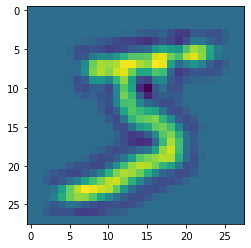

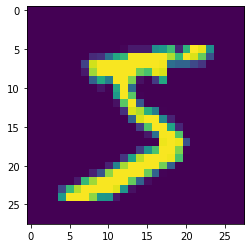

In [101]:
receptive_field_output = receptive_field(input)

plt.imshow(receptive_field_output)
plt.show()
plt.imshow(input)
plt.show()

In [4]:
# Simulation Parameters
image_train_time = 350 #Training time for every image
past_window = -5
epochs = 1

# Input Parameters
training_set_path= "./MNIST/training/"
image_size = (28,28)
resting_potential = -70
layer1_size = image_size[0] * image_size[1] # Number of neurons in first layer
layer2_size =  800  # Number of neurons in second layer

# Neuron Parameters
inhibitory_potential = -100
spike_threshold = -55
hyperpolarization_potential = -90
spike_drop_rate = 0.8
threshold_drop_rate = 0.4
min_weight = 0.00001
max_weight = 1.0

# STDP Parameters
STDP_offset = 0
sigma = 0.01
A_plus = 0.8
A_minus = 0.8
tau_plus = 5
tau_minus = 5
mu=0.9

In [5]:
class Neuron:
	def hyperpolarization(self, time_step):
		self.potential = hyperpolarization_potential
		self.rest_until = time_step + self.refractory_period

	def inhibit(self, time_step):
		self.potential = inhibitory_potential
		self.rest_until = time_step + self.refractory_period

	def initial(self):
		self.adaptive_spike_threshold = spike_threshold
		self.rest_until = -1
		self.refractory_period = 15 #(us)
		self.potential = resting_potential

In [6]:
# STDP reinforcement learning curve
def STDP_weighting_curve(time_step: int):
	if time_step>0:
		return -A_plus*(np.exp(-float(time_step)/tau_plus)-STDP_offset)
	if time_step<=0:
		return A_minus*(np.exp(float(time_step)/tau_minus)-STDP_offset)


# STDP weight update rule
def update_synapse(synapse_weight, weight_factor):
	if weight_factor<0:
		return synapse_weight + sigma * weight_factor * (synapse_weight - abs(min_weight))**mu
	elif weight_factor>0:
		return synapse_weight + sigma * weight_factor * (max_weight - synapse_weight)**mu

In [7]:
def visualize_weights(weights, num):
	weights = np.array(weights)
	weights = np.reshape(weights, image_size)
	img = np.zeros(image_size)
	for x_coordinate in range(image_size[0]):
		for y_coordinate in range(image_size[1]):
			img[x_coordinate][y_coordinate] = int(np.interp(weights[x_coordinate][y_coordinate], [min_weight, max_weight], [0,255]))

	imageio.imwrite('neuron_' + str(num) + '.png' ,img.astype(np.uint8))
	return img

In [34]:
potentials = []
potential_thresholds = []
for image_path in range(layer2_size):
    potentials.append([])
    potential_thresholds.append([])

time_of_learning = np.arange(1, image_train_time + 1, 1)

output_layer = []

# Creating Second Layer
for image_path in range(layer2_size):
    neuron = Neuron()
    neuron.initial() # TODO In die __init__()
    output_layer.append(neuron)

# Random synapse matrix	initialization
synapses = np.random.uniform(low=0.95, high=1.0, size=(layer2_size , layer1_size)) # np.ones((layer2_size , layer1_size)) 
max_weight = np.max(synapses)
synapse_memory = np.zeros((layer2_size ,layer1_size))

# Creating labels corresponding to neuron
label_neuron = np.repeat(-1 , layer2_size)

for epoch in range(epochs):
    for folder in os.listdir('./MNIST/training/'):
        for image_path in os.listdir("./MNIST/training/" + folder + "/")[:80]:
            time_start = time.time()

            img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)

            # Convolving image with receptive field and encoding to generate spike train
            spike_train = np.array(encode_image_to_spike_train(receptive_field(img)))

            # Local variables
            winner_index = None
            count_spikes = np.zeros(layer2_size)
            current_potentials = np.zeros(layer2_size)

            # Leaky integrate and fire neuron dynamics
            for time_step in time_of_learning:

                for neuron_index, neuron in enumerate(output_layer):
                    if(neuron.rest_until < time_step):
                        # Increase potential according to the sum of synapses inputs
                        neuron.potential += np.dot(synapses[neuron_index], spike_train[: , time_step])

                        if(neuron.potential > resting_potential):
                            neuron.potential -= spike_drop_rate

                            if(neuron.adaptive_spike_threshold > spike_threshold):
                                    neuron.adaptive_spike_threshold -= threshold_drop_rate
                                    
                        current_potentials[neuron_index] = neuron.potential

                    potentials[neuron_index].append(neuron.potential) # Only for plotting: Changing potential overtime
                    potential_thresholds[neuron_index].append(neuron.adaptive_spike_threshold) # Only for plotting: Changing threshold overtime

                winner_index = np.argmax(current_potentials)
                winner_neuron = output_layer[winner_index]

                # Check for spikes and update weights
                if current_potentials[winner_index] > winner_neuron.adaptive_spike_threshold:
                    count_spikes[winner_index] += 1

                    winner_neuron.hyperpolarization(time_step)
                    winner_neuron.adaptive_spike_threshold += 1 # Adaptive Membrane/Homoeostasis: Increasing the threshold of the neuron

                    for layer1_index in range(layer1_size):
                        for past_time_step in range(0, past_window-1, -1): # if presynaptic spike came before postsynaptic spike
                            if 0 <= time_step + past_time_step < image_train_time + 1:
                                if spike_train[layer1_index][time_step + past_time_step] == 1:  # if presynaptic spike was in the tolerance window
                                    synapses[winner_index][layer1_index] = update_synapse(synapses[winner_index][layer1_index], STDP_weighting_curve(past_time_step))  # strengthen weights
                                    synapse_memory[winner_index][layer1_index] = 1 # TODO Possible Reset necessary - somewhere?!?!?
                                    break
                        if synapse_memory[winner_index][layer1_index] != 1:  # if presynaptic spike was not in the tolerance window, reduce weights of that synapse
                            synapses[winner_index][layer1_index] = update_synapse(synapses[winner_index][layer1_index], STDP_weighting_curve(1))

                    # Inhibit all LOOSERS
                    for looser_neuron_index, looser_neuron in enumerate(output_layer):
                        if looser_neuron_index != winner_index:
                            if (looser_neuron.potential > looser_neuron.adaptive_spike_threshold):
                                count_spikes[looser_neuron_index] += 1

                            looser_neuron.inhibit(time_step) # TODO So nothing happens for a few time steps afterwards?!?!?!?

            # bring neuron potentials to rest
            for neuron_index, neuron in enumerate(output_layer):
                neuron.initial()

            label_neuron[winner_index] = int(folder)

            # print("Image: " + i + " Spike Count = ", count_spikes)
            print("Learning Neuron: ", np.argmax(count_spikes))
            print("Learning duration: ", time.time() - time_start)
            # to write intermediate synapses for neurons
            # for p in range(layer2_size):
            #		reconst_weights(synapse[p],str(p)+"_epoch_"+str(k))

""" print(count_spikes)
# Plotting
ttt = np.arange(0,len(potentials[0]),1)
for i in range(layer2_size):
    axes = plt.gca()
    plt.plot(ttt, potential_thresholds[i], 'r' )
    plt.plot(ttt, potentials[i])
    plt.show() """

# Reconstructing weights to analyze training
for layer2_index in range(layer2_size):
    if label_neuron[layer2_index] == -1:
        for layer1_index in range(layer1_size):
            synapses[layer2_index][layer1_index] = 0
    visualize_weights(synapses[layer2_index], str(layer2_index) + "_final")
np.savetxt("visualized_weights/weights.csv", synapses, delimiter=",")
np.savetxt("visualized_weights/labels.csv", label_neuron, delimiter=',')


NotADirectoryError: [Errno 20] Not a directory: './MNIST/training/.DS_Store/'

In [35]:
#time series 
time_of_learning = np.arange(1, image_train_time+1, 1)
output_layer = []
# creating the hidden layer of neurons

#synapse matrix
synapses = np.zeros((layer2_size,layer1_size))
#learned weights
learned_weights=pd.read_csv("weights.csv",header=None)
neuron_labels=pd.read_csv("labels.csv",header=None)
labels_matrix=np.array(neuron_labels.values)
weight_matrix = np.array(learned_weights.values)

layer1_size = weight_matrix.shape[1] # Number of neurons in first layer
layer2_size = weight_matrix.shape[0] # Number of neurons in second layer

for layer2_index in range(layer2_size):
	neuron = Neuron() # TODO Why no initial method?
	output_layer.append(neuron)
	synapses[layer2_index] = weight_matrix[layer2_index]


predicted_class=[]
actual_class=[]
prediction_count=np.zeros((layer2_size,layer2_size))
for folder in range(10):
	images_path='./MNIST/testing/' + str(folder) + '/'
	
	for image_name in os.listdir(images_path)[:10]:
		time_start = time.time()
		
		count_spikes = np.zeros((layer2_size,1))

		#read the image to be classified
		image = imageio.imread(images_path + image_name)

		#initialize the potentials of output neurons
		for neuron in output_layer:
			neuron.initial()

		#generate spike trains. Select between deterministic and stochastic
		spike_train = np.array(encode_image_to_spike_train(receptive_field(image)))

		#flag for lateral inhibition
		f_spike = 0 # TODO Do we need this?
		current_potentials = np.zeros((layer2_size,1))
		winner_index = None
		for time_step in time_of_learning:
				for layer2_index, neuron in enumerate(output_layer):

					if(neuron.rest_until < time_step):
						neuron.potential = neuron.potential + np.dot(synapses[layer2_index], spike_train[:,time_step])

						if(neuron.potential>resting_potential):
							neuron.potential -= spike_drop_rate
							
					current_potentials[layer2_index] = neuron.potential

				winner_index = np.argmax(current_potentials)

				for layer2_index, neuron in enumerate(output_layer):
					if(layer2_index == winner_index):
						if(current_potentials[layer2_index] > neuron.adaptive_spike_threshold):
							count_spikes[layer2_index] += 1
							neuron.adaptive_spike_threshold += 1 # TODO += 1??
							neuron.hyperpolarization(time_step)

							for looser_neuron_index, looser_neuron in enumerate(output_layer):
								if looser_neuron_index != winner_index:
									if(looser_neuron.potential>looser_neuron.adaptive_spike_threshold):
										looser_neuron.inhibit(time_step)
							break
		
		#print(count_spikes)
		print(image_name)
		print("Predicted_class = ",labels_matrix[np.argmax(count_spikes)][0])
		print("Actual class = ",folder)
		print("Time for inference = ",time.time()-time_start)
		predicted_class.append(labels_matrix[np.argmax(count_spikes)][0])
		actual_class.append(folder)
		prediction_count[int(folder)][int(labels_matrix[np.argmax(count_spikes)][0])]+=1
		#print("Prediction for "+str(folder_number)+" : ",prediction_count[folder_number])
accuracy=(np.sum(np.array(predicted_class)==np.array(actual_class))/len(predicted_class))*100
np.savetxt("prediction_matrix.csv",prediction_count,delimiter=',')
print(accuracy)

/var/folders/7n/n7486_2d7cq6s7v2lj0hsx5r0000gn/T/ipykernel_63525/1638686222.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path + image_name)


8808.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.3415040969848633
6602.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.3314051628112793
9519.png
Predicted_class =  2.0
Actual class =  0
Time for inference =  0.32201290130615234
1623.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.36831212043762207
3020.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.3979220390319824
5337.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.3168208599090576
8388.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.3467597961425781
5684.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.33782291412353516
1390.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.32045412063598633
6400.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.35391998291015625
348.png
Predicted_class =  1.0
Actual class =  1
Time for inference =  0.433912992477